# Identifying anomalies in SCADA dataset of an onshore wind turbine for power curve modelling
In this notebook, we will explore SCADA dataset from Kelmarsh Onshore Wind farm. <br>
- **Wind turbine specification:** Senvion MM92, 2 MW rated power, 92 m rotor diameter, and 79 m hub height, cut-in wind speed of 3 m/s, rated wind speed of 12.5 m/s and cut-out wind speed of 24.9 m/s <br>
- **Audience:** Wind energy enthausists
- **Objective:** Understanding Anomalies in SCADA dataset of wind turbine to improve power curve modeling
<br> 
What are Anomalies? <br>
Anomalies can arise from weather changes, maintenance, or system malfunctions. <br>



What are Anomalies? <br>
Anomalies can arise from weather changes, maintenance, or system malfunctions. 

Power equation : 
$$ P = \frac{1}{2} \pi R^2 \rho v^3 C_p(\beta, \lambda) $$

P = power <br>
R = rotor radius R <br>
𝜌 = air density <br>
v = wind speed <br>
𝐶𝑝 = power coeffficient <br>
𝛽 = blade pitch angle <br>
𝜆 = tip-speed ratio <br>

<img src="Turbine+Trim.jpg" alt="Turbine+Trim" width="400" height="300">

## 1. Data acquisition and preprocessing
The data sets used in this study have been collected from this website https://zenodo.org/records/5841834. <br>
Why is preprocessing the data important? <br>
- Preprocessing is crucial because SCADA datasets often contain missing values caused by sensor failures, turbine downtime, or technical issues. It enables us to improve decision-making regarding how to handle the missing data, whether through dropping or imputation.

#### Load dependencies


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Load dataset
We have 2 datasets:<br>
- Status_XXX.csv: contains description of status of wind turbine
- Turbine_data_XXX.csv: contains various observables of the turbine recorded by SCADA system 
<br>
Our initial task is to explore these datasets to understand the information they contain and determine their relevance to our study.

In [2]:
# Load Status dataset
status = pd.read_csv('./data/Status_Kelmarsh_1_2021-01-01_-_2021-07-01_228.csv', delimiter=',', skiprows =9)
status.head(20)

,Timestamp start,Timestamp end,Duration,Status,Code,Message,Comment,Service contract category,IEC category
0,2020-12-31 04:43:55,2021-01-01 16:46:58,36:03:03,Stop,6540,Icing (anemometer),NaN,External stop (climate) (6),Out of Environmental Specification
1,2020-12-31 08:59:28,2021-01-01 16:46:58,31:47:30,Informational,6542,Reset of icing st. cd. possible,NaN,System OK (32),Full Performance
2,2021-01-01 09:47:52,2021-01-01 10:13:58,00:26:06,Communication,9997,Data communication unavailable,NaN,NaN,NaN
3,2021-01-01 16:46:58,-,-,Informational,0,System OK,NaN,System OK (32),Full Performance
4,2021-01-01 16:46:58,-,-,Informational,100130,Automatic start-up,NaN,NaN,Full Performance
5,2021-01-01 16:46:58,2021-01-01 16:51:38,00:04:40,Informational,0,System OK,NaN,System OK (32),Full Performance
6,2021-01-01 16:49:01,-,-,Informational,100180,Run-up,NaN,NaN,Technical Standby
7,2021-01-01 16:51:25,-,-,Informational,100190,Mains connection,NaN,NaN,Full Performance
8,2021-01-01 16:51:35,-,-,Informational,100200,Mains run-up,NaN,NaN,Full Performance
9,2021-01-01 16:51:38,2021-01-01 17:03:33,00:11:55,Informational,1552,Gearbox warm-up stage,NaN,Operating states (28),Full Performance


**Insights:** Some data entries feature a "-" in the "Timestamp end" column. We will replace them with the Timestart from the subsequent line.

In [3]:
# Replace entries with '-' in the Timestamp end column with NaN
status['Timestamp end'] = status['Timestamp end'].replace('-', np.nan)

# Iterate over rows
for idx, row in status.iterrows():
    if pd.isna(row['Timestamp end']) and idx +1 < len(status):
        # Replace '-' with the Timestamp start from the next line
        status.at[idx, 'Timestamp end'] = status.at[idx + 1, 'Timestamp start']
status.head(20)

,Timestamp start,Timestamp end,Duration,Status,Code,Message,Comment,Service contract category,IEC category
0,2020-12-31 04:43:55,2021-01-01 16:46:58,36:03:03,Stop,6540,Icing (anemometer),NaN,External stop (climate) (6),Out of Environmental Specification
1,2020-12-31 08:59:28,2021-01-01 16:46:58,31:47:30,Informational,6542,Reset of icing st. cd. possible,NaN,System OK (32),Full Performance
2,2021-01-01 09:47:52,2021-01-01 10:13:58,00:26:06,Communication,9997,Data communication unavailable,NaN,NaN,NaN
3,2021-01-01 16:46:58,2021-01-01 16:46:58,-,Informational,0,System OK,NaN,System OK (32),Full Performance
4,2021-01-01 16:46:58,2021-01-01 16:46:58,-,Informational,100130,Automatic start-up,NaN,NaN,Full Performance
5,2021-01-01 16:46:58,2021-01-01 16:51:38,00:04:40,Informational,0,System OK,NaN,System OK (32),Full Performance
6,2021-01-01 16:49:01,2021-01-01 16:51:25,-,Informational,100180,Run-up,NaN,NaN,Technical Standby
7,2021-01-01 16:51:25,2021-01-01 16:51:35,-,Informational,100190,Mains connection,NaN,NaN,Full Performance
8,2021-01-01 16:51:35,2021-01-01 16:51:38,-,Informational,100200,Mains run-up,NaN,NaN,Full Performance
9,2021-01-01 16:51:38,2021-01-01 17:03:33,00:11:55,Informational,1552,Gearbox warm-up stage,NaN,Operating states (28),Full Performance


**Load observable dataset**

In [4]:
# Load SCADA dataset
original_data = pd.read_csv('./data/Turbine_Data_Kelmarsh_1_2021-01-01_-_2021-07-01_228.csv', delimiter=',', skiprows =9)
original_data.head(5)

,# Date and time,Wind speed (m/s),"Wind speed, Standard deviation (m/s)","Wind speed, Minimum (m/s)","Wind speed, Maximum (m/s)",Long Term Wind (m/s),Wind speed Sensor 1 (m/s),"Wind speed Sensor 1, Standard deviation (m/s)","Wind speed Sensor 1, Minimum (m/s)","Wind speed Sensor 1, Maximum (m/s)",...,Tower Acceleration y (mm/ss),"Tower Acceleration X, Min (mm/ss)","Tower Acceleration X, Max (mm/ss)","Tower Acceleration Y, Min (mm/ss)","Tower Acceleration Y, Max (mm/ss)","Drive train acceleration, Max (mm/ss)","Drive train acceleration, Min (mm/ss)","Drive train acceleration, StdDev (mm/ss)","Tower Acceleration X, StdDev (mm/ss)","Tower Acceleration Y, StdDev (mm/ss)"
0,2021-01-01 00:00:00,6.204656,0.288911,5.740500,6.652500,7.1,6.024862,0.250893,5.524053,6.599847,...,7.071378,1.427933,8.543495,2.525917,12.500390,4.062269,4.062269,0.0,2.145020,3.111913
1,2021-01-01 00:10:00,5.858888,0.641860,4.554375,6.753750,7.1,6.006086,0.466189,4.880189,6.593579,...,10.096306,1.621035,9.721189,4.186926,23.431389,4.030238,4.030238,0.0,2.380230,5.454331
2,2021-01-01 00:20:00,6.069038,0.713886,4.822125,7.682625,7.1,6.035623,0.916521,3.806186,7.548481,...,12.734161,3.671053,11.068409,2.899770,24.404755,3.969925,3.969925,0.0,1.708781,6.177721
3,2021-01-01 00:30:00,5.918869,0.482376,4.878375,6.597375,7.1,5.909671,0.546195,4.635419,6.862826,...,11.858300,1.935947,8.988639,5.925399,22.181843,4.012971,4.012971,0.0,2.014140,4.617657
4,2021-01-01 00:40:00,5.408306,0.333004,4.638375,5.931750,7.1,5.466144,0.466636,4.655418,6.228513,...,12.953673,6.241996,22.886889,3.846191,26.298719,3.996206,3.996206,0.0,3.828679,6.402466


** Merge the two data**

In [5]:
# Convert timestamp columns to datetime format 
original_data['# Date and time'] = pd.to_datetime(original_data['# Date and time'])
status['Timestamp start'] = pd.to_datetime(status['Timestamp start'])
status['Timestamp end'] = pd.to_datetime(status['Timestamp end'])

# Merge dataframes based on timestamp columns
merged_df = pd.merge_asof(original_data, status, left_on='# Date and time', right_on='Timestamp start')

# Drop unnecessary columns if needed
merged_df = merged_df.drop(['Timestamp start', 'Timestamp end'], axis=1)

# Display the merged dataframe
merged_df


,# Date and time,Wind speed (m/s),"Wind speed, Standard deviation (m/s)","Wind speed, Minimum (m/s)","Wind speed, Maximum (m/s)",Long Term Wind (m/s),Wind speed Sensor 1 (m/s),"Wind speed Sensor 1, Standard deviation (m/s)","Wind speed Sensor 1, Minimum (m/s)","Wind speed Sensor 1, Maximum (m/s)",...,"Drive train acceleration, StdDev (mm/ss)","Tower Acceleration X, StdDev (mm/ss)","Tower Acceleration Y, StdDev (mm/ss)",Duration,Status,Code,Message,Comment,Service contract category,IEC category
0,2021-01-01 00:00:00,6.204656,0.288911,5.740500,6.652500,7.1,6.024862,0.250893,5.524053,6.599847,...,0.00,2.145020,3.111913,31:47:30,Informational,6542,Reset of icing st. cd. possible,NaN,System OK (32),Full Performance
1,2021-01-01 00:10:00,5.858888,0.641860,4.554375,6.753750,7.1,6.006086,0.466189,4.880189,6.593579,...,0.00,2.380230,5.454331,31:47:30,Informational,6542,Reset of icing st. cd. possible,NaN,System OK (32),Full Performance
2,2021-01-01 00:20:00,6.069038,0.713886,4.822125,7.682625,7.1,6.035623,0.916521,3.806186,7.548481,...,0.00,1.708781,6.177721,31:47:30,Informational,6542,Reset of icing st. cd. possible,NaN,System OK (32),Full Performance
3,2021-01-01 00:30:00,5.918869,0.482376,4.878375,6.597375,7.1,5.909671,0.546195,4.635419,6.862826,...,0.00,2.014140,4.617657,31:47:30,Informational,6542,Reset of icing st. cd. possible,NaN,System OK (32),Full Performance
4,2021-01-01 00:40:00,5.408306,0.333004,4.638375,5.931750,7.1,5.466144,0.466636,4.655418,6.228513,...,0.00,3.828679,6.402466,31:47:30,Informational,6542,Reset of icing st. cd. possible,NaN,System OK (32),Full Performance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26059,2021-06-30 23:10:00,3.840000,0.500000,2.100000,5.280000,5.3,4.070000,0.420000,2.690000,5.280000,...,0.07,NaN,NaN,01:29:35,Informational,0,System OK,NaN,System OK (32),Full Performance
26060,2021-06-30 23:20:00,4.130000,0.460000,2.270000,5.310000,5.3,4.420000,0.380000,3.280000,5.430000,...,0.08,NaN,NaN,01:29:35,Informational,0,System OK,NaN,System OK (32),Full Performance
26061,2021-06-30 23:30:00,3.780000,0.720000,1.640000,5.440000,5.3,4.060000,0.680000,2.210000,5.290000,...,0.10,NaN,NaN,01:29:35,Informational,0,System OK,NaN,System OK (32),Full Performance
26062,2021-06-30 23:40:00,1.920000,0.530000,0.500000,3.730000,5.3,2.080000,0.490000,1.230000,3.550000,...,0.12,NaN,NaN,01:29:35,Informational,0,System OK,NaN,System OK (32),Full Performance


In [6]:
# Get total operating hours and calculate mean time interval in the dataset
merged_df["# Date and time"] = pd.to_datetime(merged_df["# Date and time"])
time_interval_mean = merged_df["# Date and time"].diff().mean()
time_interval = time_interval_mean.total_seconds()/60
operating_time = merged_df["# Date and time"].diff().sum()

# Convert operating time to total hours

total_hours = operating_time.total_seconds()/3600
print(f'The underlying dataset is based on an onshore wind turbine with a total operating hours of {round(total_hours,0)} hrs')
print(f'The observables are measured at {time_interval}-min intervals.')

The underlying dataset is based on an onshore wind turbine with a total operating hours of 4344.0 hrs
The observables are measured at 10.0-min intervals.


**Insights:** 10-min time interval is assumed to be sufficient to analyse performance of the turbine and energy production, and hence good to use in the present study. Shorter time intervals may be necessary if we were to analyse other parameters that are sensitive to the response time of the SCADA system and the control mechanism.

#### Check data
- What is the data type of each observable?
- How many numbers of rows and columns?
- What observables are contained?

In [7]:
# Display information about the dataset
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26064 entries, 0 to 26063
Columns: 306 entries, # Date and time to IEC category
dtypes: datetime64[ns](1), float64(295), int64(5), object(5)
memory usage: 61.0+ MB


In [8]:
# Get the shape of the dataset
merged_df.shape

(26064, 306)

In [9]:
# Get the number of columns
len(merged_df.columns)

306

In [10]:
# Get the column names
for col in merged_df.columns:
    print(col)

# Date and time
Wind speed (m/s)
Wind speed, Standard deviation (m/s)
Wind speed, Minimum (m/s)
Wind speed, Maximum (m/s)
Long Term Wind (m/s)
Wind speed Sensor 1 (m/s)
Wind speed Sensor 1, Standard deviation (m/s)
Wind speed Sensor 1, Minimum (m/s)
Wind speed Sensor 1, Maximum (m/s)
Wind speed Sensor 2 (m/s)
Wind speed Sensor 2, Standard deviation (m/s)
Wind speed Sensor 2, Minimum (m/s)
Wind speed Sensor 2, Maximum (m/s)
Density adjusted wind speed (m/s)
Wind direction (°)
Nacelle position (°)
Wind direction, Standard deviation (°)
Wind direction, Minimum (°)
Wind direction, Maximum (°)
Nacelle position, Standard deviation (°)
Nacelle position, Minimum (°)
Nacelle position, Maximum (°)
Vane position 1+2 (°)
Vane position 1+2, Max (°)
Vane position 1+2, Min (°)
Vane position 1+2, StdDev (°)
Energy Export (kWh)
Energy Export counter (kWh)
Energy Import (kWh)
Energy Import counter (kWh)
Lost Production (Contractual) (kWh)
Lost Production (Time-based IEC B.2.2) (kWh)
Lost Production (Tim

## 2. Feature selection and extraction
Important signals which are of useful for this study are identified and extracted from the dataset.


In [11]:
# Create a new dataframe for the present study
data = merged_df[['# Date and time',
                      'Wind speed (m/s)', 
                      'Density adjusted wind speed (m/s)',
                      'Wind direction (°)',
                      'Nacelle position (°)',
                      'Reactive power (kvar)',
                      'Power (kW)',
                      'Potential power default PC (kW)',
                      'Rotor speed (RPM)','Generator RPM (RPM)','Gearbox speed (RPM)',
                      'Blade angle (pitch position) A (°)', 'Blade angle (pitch position) B (°)', 'Blade angle (pitch position) C (°)',
                      'Message','IEC category'
]]
data.head(5)

,# Date and time,Wind speed (m/s),Density adjusted wind speed (m/s),Wind direction (°),Nacelle position (°),Reactive power (kvar),Power (kW),Potential power default PC (kW),Rotor speed (RPM),Generator RPM (RPM),Gearbox speed (RPM),Blade angle (pitch position) A (°),Blade angle (pitch position) B (°),Blade angle (pitch position) C (°),Message,IEC category
0,2021-01-01 00:00:00,6.204656,6.251327,304.833128,313.365387,0.0,-1.338018,442.982686,0.0,1.463680,0.039500,89.989998,90.0,89.989998,Reset of icing st. cd. possible,Full Performance
1,2021-01-01 00:10:00,5.858888,5.905937,299.338570,313.365387,0.0,-2.593343,364.753085,0.0,1.408302,1.811527,89.989998,90.0,89.989998,Reset of icing st. cd. possible,Full Performance
2,2021-01-01 00:20:00,6.069038,6.123070,299.172669,313.365387,0.0,-1.319346,408.535527,0.0,3.158101,5.818842,89.989998,90.0,89.989998,Reset of icing st. cd. possible,Full Performance
3,2021-01-01 00:30:00,5.918869,5.974207,296.647785,313.365387,0.0,-1.118750,375.909580,0.0,1.869531,3.619358,89.989998,90.0,89.989998,Reset of icing st. cd. possible,Full Performance
4,2021-01-01 00:40:00,5.408306,5.458421,291.827335,313.365387,0.0,-2.800342,280.944952,0.0,1.857184,4.142414,89.989998,90.0,89.989998,Reset of icing st. cd. possible,Full Performance


In [12]:
# Get the shape of the dataset
data.shape

(26064, 16)

In [13]:
# Check the number of missing values in each column of the new dataset
data.isnull().sum()

# Date and time                          0
Wind speed (m/s)                        48
Density adjusted wind speed (m/s)     2243
Wind direction (°)                      48
Nacelle position (°)                    48
Reactive power (kvar)                   48
Power (kW)                              48
Potential power default PC (kW)         48
Rotor speed (RPM)                       48
Generator RPM (RPM)                     48
Gearbox speed (RPM)                   2243
Blade angle (pitch position) A (°)    2243
Blade angle (pitch position) B (°)    2243
Blade angle (pitch position) C (°)    2243
Message                                  0
IEC category                           879
dtype: int64

Insights: There are missing values across all parameters we would like to futher analyse. The percentage of missing values in density adjusted wind speed, and balde pitch angle are relatively high. <br>
Although there are only 48 missing values in other important parameters, they are all crucial in wind energy performance analysis, and energy yield assessment. <br> Furthermore, the correlation amongs these parameters is intrinsic. The inflow Wind speed causes the rotor rotate. Its rotation is transmitted throught gears to the rotation of the high-speed shaft at the generator, ultimately leading to generation of power. 
<br> Deviations between generated active power and current could only occur, if large amounts of reactive power are generated. So this is the reason why we see the same percentage of missing values in these parameters.
<br> Handling of missing values, outliers, noise reduction, filtering, and transforming the data are imperative. <br>
Several methods are available for imputing missing data in wind farm datasets.
<br> Due to the sensitivity of these methods to outliers, a thorough identification of outliers within the dataset will be conducted in the following data exploration section.

### 2. Exploratory Data Analysis

In [14]:
# Get statistics for your DataFrame to identify potential outliers
data.describe()

,Wind speed (m/s),Density adjusted wind speed (m/s),Wind direction (°),Nacelle position (°),Reactive power (kvar),Power (kW),Potential power default PC (kW),Rotor speed (RPM),Generator RPM (RPM),Gearbox speed (RPM),Blade angle (pitch position) A (°),Blade angle (pitch position) B (°),Blade angle (pitch position) C (°)
count,26016.000000,23821.000000,26016.000000,26016.000000,26016.000000,26016.000000,26016.000000,26016.000000,26016.000000,23821.000000,23821.000000,23821.000000,23821.000000
mean,5.750563,5.839700,178.961618,180.399330,-193.604404,579.764966,535.143056,9.727392,1154.913543,1166.548057,8.851801,8.863499,8.858162
std,2.877248,2.939097,103.734005,103.981620,178.442605,654.381396,632.604915,4.535585,536.529916,545.483733,20.053368,20.042961,20.071179
min,0.229894,0.230337,0.012631,0.203796,-599.141935,-17.010895,0.000000,0.000000,0.000000,0.000000,-170.119995,-170.169998,-170.119995
25%,3.594361,3.616172,73.980208,74.097717,-291.292275,69.819445,63.982690,8.149787,969.523314,970.485374,0.000000,0.000000,0.000000
50%,5.311006,5.380597,199.630070,201.414307,-128.218609,297.875525,262.847086,9.891573,1175.535164,1194.154066,0.162500,0.165000,0.164000
75%,7.410848,7.591526,262.718061,263.976013,-61.325040,893.487160,782.223379,13.663272,1620.286695,1659.207367,3.667500,3.675000,3.674500
max,22.173118,22.106207,359.990140,359.945271,2.156507,2076.354102,2050.000000,15.302300,1811.751337,1816.579691,92.570000,92.580002,92.959999


Insights: There are outliers in each parameters of the dataset. Power outliers can be easily detected as in figure below.<br>

<img src="Explantory2.jpg" alt="Explantory2" width="1200" height="1000">

#### Identifying potential anomalities

In the context of wind turbine SCADA, anomalities refer to noises in power output, sensor failures, and unexpected behaviour in wind speed. Scatter diagrams are a good way to identify anomalities in wind turbine. They provide a visual representation that helps in the identification and understanding of these deviations, helping us better understand potential issues in the system.

<Figure size 1440x1296 with 0 Axes>

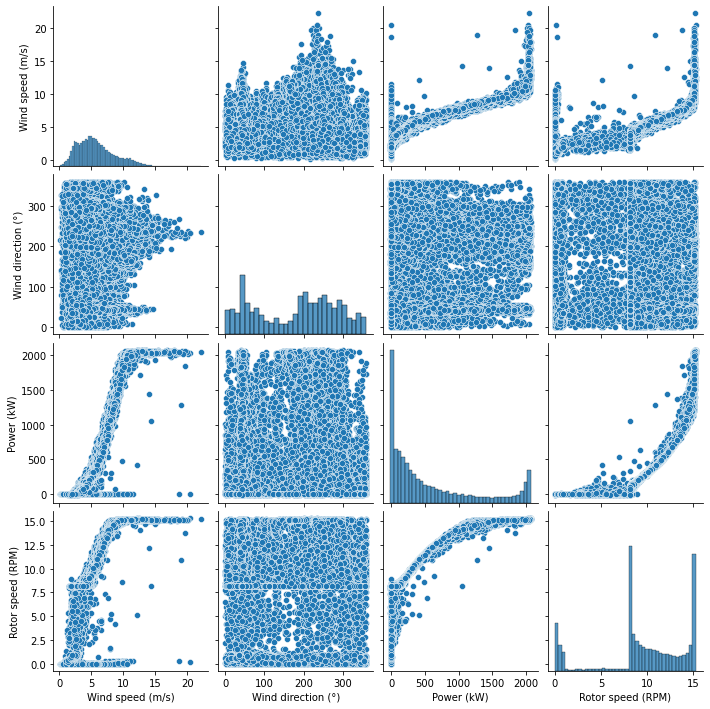

In [15]:
# Scatter plot 
plt.figure(figsize=(20, 18))

# Create scatter plots for selected numerical columns
sns.pairplot(data[['Wind speed (m/s)', 
                   'Wind direction (°)',
                   'Power (kW)',
                    'Rotor speed (RPM)']])   
plt.show()

Text(0.5, 1.0, 'Measured hub-height wind speed frequency distribution')

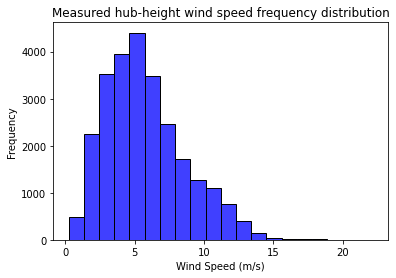

In [16]:
sns.histplot(data['Wind speed (m/s)'], bins=20, kde=False, color='blue')

# Set plot labels and title
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Measured hub-height wind speed frequency distribution')

Insights: The dataset exhibits outliers in various parameters. For instance, the wind speed histogram provides insights into the distribution of different wind speeds. From the wind speed histogram, it is evident that the occurence of wind speed higher than 13 m/s are relatively low.
<br>Power outliers can be easily detected as in figure below. <br>
Power outliers can be categorized into sparsed outliers and stacked outliers. Sparsed outliers are mainly due to noises, and a transition from start to stop stage whereas stacked outliers are due to shutdown of the turbine and wind curtailment. 
<br>
<img src="power2.jpg" alt="Power2" width="400" height="300">

**Apply filtering to power outliers**

First and foremost, we will filter out rows with negative power values because they are physically unrelastic for a wind turbine. Filtering out these entries helps ensure that the dataset only includes valid and meaningful power generation data for the present study. <br>
Secondly, wind turbines typically have a cut-in wind speed at which the turbine should starts generating power. By removing rows with wind speeds below 3 m/s, we can focus on data where the turbine is more likely to be operating within its designed performance range, providing reliable insights.
<br>
Therefore, it is crucial to filter out any power outliers which is less than 0, while the wind speed is less than 3 m/s.

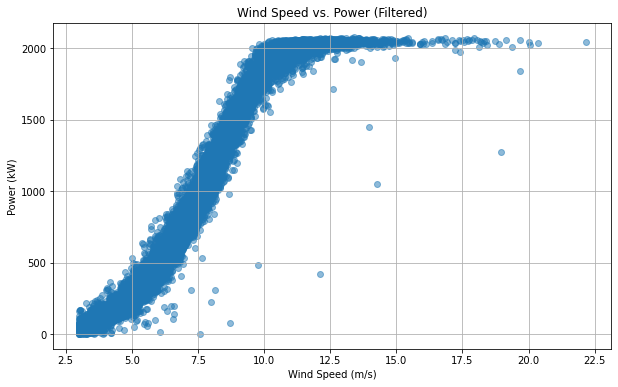

In [17]:
# First filter out rows with negative power values and wind speed less than 3 m/s.

filtered_data = data[(data['Power (kW)'] >= 0) & (data['Wind speed (m/s)'] >= 3)]
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['Wind speed (m/s)'], filtered_data['Power (kW)'], alpha=0.5)
plt.title('Wind Speed vs. Power (Filtered)')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.grid(True)
plt.show()


In [18]:
filtered_data.isnull().sum()

# Date and time                          0
Wind speed (m/s)                         0
Density adjusted wind speed (m/s)     1751
Wind direction (°)                       0
Nacelle position (°)                     0
Reactive power (kvar)                    0
Power (kW)                               0
Potential power default PC (kW)          0
Rotor speed (RPM)                        0
Generator RPM (RPM)                      0
Gearbox speed (RPM)                   1751
Blade angle (pitch position) A (°)    1751
Blade angle (pitch position) B (°)    1751
Blade angle (pitch position) C (°)    1751
Message                                  0
IEC category                           644
dtype: int64

**Insights:** Although there are no more missing values in majority of the observables, noises are still observed as depicted in the above figure. These noise patterns may introduce biases in subsequent analyses. In an effort to mitigate these effects, various noise-cleaning methods were explored, and finally Mahalanobis_distances method proves to be a good method to clean the data. The significance of choosing a suitable imputing methods is underscored.

The expression is given by:

$$ {d}_n = \sqrt{(\mathbf{x}_i - \bar{x})^T \mathbf{C}^{-1} (\mathbf{x}_i - \bar{x})} $$




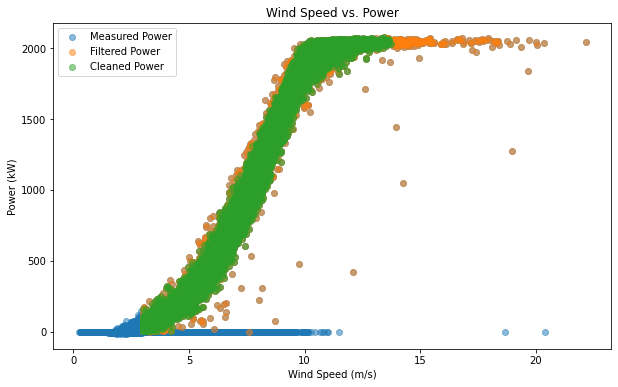

In [19]:
from scipy.stats import chi2
from sklearn.covariance import MinCovDet

def mahalanobis_method(data):
    # Deep copy to avoid modifying the original DataFrame
    cleaned_data = filtered_data[['Power (kW)', 
                       'Wind speed (m/s)',
                       'Wind direction (°)',
                       'Nacelle position (°)',
                        'Reactive power (kvar)',                    
                        'Potential power default PC (kW)',
                        'Rotor speed (RPM)','Generator RPM (RPM)']] 
    
    
    # Calculate Mahalanobis distance
    x_minus_mu = cleaned_data - np.mean(cleaned_data)
    
    # Covariance
    cov = np.cov(cleaned_data.values.T)  
    # Inverse covariance
    inv_covmat = np.linalg.inv(cov)  
    left_term = np.dot(x_minus_mu, inv_covmat) 
    mahal = np.dot(left_term, x_minus_mu.T)
    
    #Mahalanobis distance
    md = np.sqrt(mahal.diagonal())
    
     # Cut-off point
    C = np.sqrt(chi2.ppf((1 - 0.01), df=cleaned_data.shape[1]))  
    
    outlier_mask = md > C
    
    # Remove outliers from the DataFrame
    filtered_data_cleaned = filtered_data[~outlier_mask]
    
    return filtered_data_cleaned

# Apply Mahalanobis Distance method to remove sparse outliers
filtered_data_cleaned = mahalanobis_method(filtered_data)

# Plot Wind speed against Power after cleaning sparse outliers
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Wind speed (m/s)'], merged_df['Power (kW)'], alpha=0.5, label='Measured Power')
plt.scatter(filtered_data['Wind speed (m/s)'], filtered_data['Power (kW)'], alpha=0.5, label='Filtered Power')
plt.scatter(filtered_data_cleaned['Wind speed (m/s)'], filtered_data_cleaned['Power (kW)'], alpha=0.5, label='Cleaned Power')
plt.title('Wind Speed vs. Power')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()


In [20]:
# Inspect if there are still NaN in cleaned dataset
filtered_data_cleaned.isnull().sum()

# Date and time                          0
Wind speed (m/s)                         0
Density adjusted wind speed (m/s)     1665
Wind direction (°)                       0
Nacelle position (°)                     0
Reactive power (kvar)                    0
Power (kW)                               0
Potential power default PC (kW)          0
Rotor speed (RPM)                        0
Generator RPM (RPM)                      0
Gearbox speed (RPM)                   1665
Blade angle (pitch position) A (°)    1665
Blade angle (pitch position) B (°)    1665
Blade angle (pitch position) C (°)    1665
Message                                  0
IEC category                           577
dtype: int64

**Insights:** Now the outliers have been removed, and the clean dataset seems good to use for further analysis. Still there are a number of missing values in pitch angle of the blades, gearbox speed, and density adjusted wind speed. Assuming these values are due to sensor failures, their missing values will be handled by interpolation-based methods.

#### Inspecting missing data

In this step, our focus is solely on evaluating the feasibility of dropping missing data related to pitch angle. For that, we will look at turbine status specifically
"IEC category" and "Message". At first, we will inspect IEC category to see if the turbine was non-perational or encountered faults. Subsequently, we will investigate whether the absence of data is attributable to communication lapses.

In [21]:
# Inspect NaN rows in IEC category
nan_IEC = filtered_data_cleaned[filtered_data_cleaned["IEC category"].isna()]
nan_IEC

,# Date and time,Wind speed (m/s),Density adjusted wind speed (m/s),Wind direction (°),Nacelle position (°),Reactive power (kvar),Power (kW),Potential power default PC (kW),Rotor speed (RPM),Generator RPM (RPM),Gearbox speed (RPM),Blade angle (pitch position) A (°),Blade angle (pitch position) B (°),Blade angle (pitch position) C (°),Message,IEC category
423,2021-01-03 22:30:00,7.24,NaN,51.220001,50.200001,-246.330002,807.179993,725.159924,13.26,1576.630005,NaN,NaN,NaN,NaN,Data communication unavailable,NaN
424,2021-01-03 22:40:00,7.21,NaN,45.930000,53.240002,-252.610001,841.520020,715.140013,13.47,1601.579956,NaN,NaN,NaN,NaN,Data communication unavailable,NaN
425,2021-01-03 22:50:00,6.67,NaN,45.259998,53.240002,-181.539993,620.159973,561.180019,12.27,1458.939941,NaN,NaN,NaN,NaN,Data communication unavailable,NaN
426,2021-01-03 23:00:00,5.89,NaN,45.660000,40.689999,-147.919998,419.959991,370.539975,10.91,1298.550049,NaN,NaN,NaN,NaN,Data communication unavailable,NaN
427,2021-01-03 23:10:00,5.69,NaN,47.119999,40.070000,-140.529999,412.690002,333.340011,10.83,1288.969971,NaN,NaN,NaN,NaN,Data communication unavailable,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23967,2021-06-16 10:30:00,3.42,NaN,221.190002,217.880005,-53.310001,82.360001,51.080006,8.28,986.849976,NaN,NaN,NaN,NaN,Data communication unavailable,NaN
23968,2021-06-16 10:40:00,4.12,NaN,207.899994,217.880005,-58.130001,130.399994,107.319987,8.40,1000.479980,NaN,NaN,NaN,NaN,Data communication unavailable,NaN
23969,2021-06-16 10:50:00,3.59,NaN,168.660004,212.619995,-58.700001,96.440002,63.659994,8.45,1006.070007,NaN,NaN,NaN,NaN,Data communication unavailable,NaN
23970,2021-06-16 11:00:00,4.50,NaN,196.460007,180.589996,-80.900002,188.649994,149.500000,9.01,1073.400024,NaN,NaN,NaN,NaN,Data communication unavailable,NaN


In [22]:
# Get unique name in "IEC category" column
nan_IEC["Message"].unique()

array(['Data communication unavailable'], dtype=object)

**Insights:** There are 520 missing data in IEC category. In "Message" column we are able to see why the data are missing. It appears soley due to the lack of data communication which in turn is caused by sensor failure or weather conditions. Now let's have a look at the power curve of these missing data.

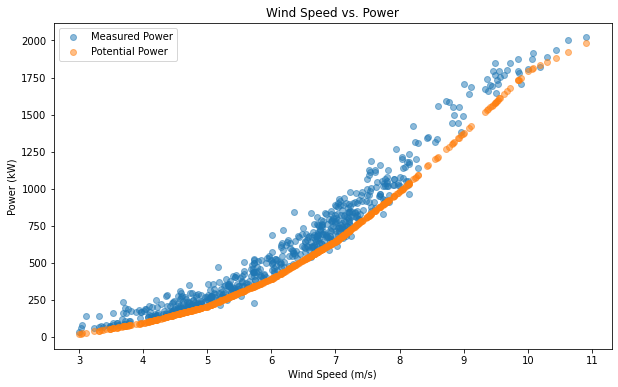

In [23]:
# Plot Wind speed against Power after cleaning sparse outliers
plt.figure(figsize=(10, 6))
plt.scatter(nan_IEC['Wind speed (m/s)'], nan_IEC['Power (kW)'], alpha=0.5, label='Measured Power')
plt.scatter(nan_IEC['Wind speed (m/s)'], nan_IEC['Potential power default PC (kW)'], alpha=0.5, label= 'Potential Power')
plt.title('Wind Speed vs. Power')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

**Insights:** The measured power curve seems to be behaving as it should be.

Now it is time to inspect missing data in blade pitch angle. As we have already seen, there are a total of 1608 missing data for blade pitch angle. We have to figure out if it is worth to drop or impute the data. For this purpose, I will have a look at "Message" column, which records turbine status. 

In [24]:
nan_IEC.isnull().sum()

# Date and time                         0
Wind speed (m/s)                        0
Density adjusted wind speed (m/s)     100
Wind direction (°)                      0
Nacelle position (°)                    0
Reactive power (kvar)                   0
Power (kW)                              0
Potential power default PC (kW)         0
Rotor speed (RPM)                       0
Generator RPM (RPM)                     0
Gearbox speed (RPM)                   100
Blade angle (pitch position) A (°)    100
Blade angle (pitch position) B (°)    100
Blade angle (pitch position) C (°)    100
Message                                 0
IEC category                          577
dtype: int64

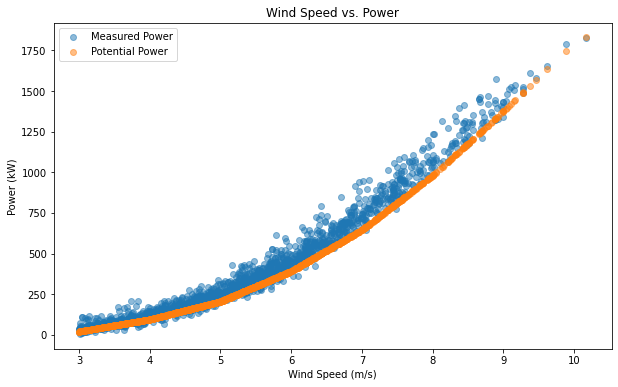

In [25]:
nan_pitch = filtered_data_cleaned[filtered_data_cleaned["Blade angle (pitch position) A (°)"].isna()]
plt.figure(figsize=(10, 6))
plt.scatter(nan_pitch['Wind speed (m/s)'], nan_pitch['Power (kW)'], alpha=0.5, label='Measured Power')
plt.scatter(nan_pitch['Wind speed (m/s)'], nan_pitch['Potential power default PC (kW)'], alpha=0.5, label= 'Potential Power')
plt.title('Wind Speed vs. Power')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

In [26]:
# Inspect NaN rows in IEC category
nan_pitch = filtered_data_cleaned[filtered_data_cleaned["Blade angle (pitch position) A (°)"].isna()]
nan_pitch['Message'].unique()

array(['Data communication unavailable', 'Mains operation', 'System OK'],
      dtype=object)

**Insights:** We have previously examined rows displaying the "Data communication unavailable" message, and they appear to be suitable for use. Additionally, the presence of the 'System OK' message indicates the proper functioning of the turbine. Mains operation means that the turbine is operating normally and generating power. 
<br>
So, in the next step, we will be imputing missing entries.

#### Handling missing data

**Imputating Using k-NN:** <br>
For pitch angle, the k nearest neighbours (k-NN) method is applied to identify the k nearest neighbors to observations with missing pitch angle data. Imputation is then performed based on the available pitch angle values within this selected neighborhood. 

In [27]:
from sklearn.impute import KNNImputer

column_to_impute = ['Density adjusted wind speed (m/s)', 'Gearbox speed (RPM)',
                                'Blade angle (pitch position) A (°)',
                                'Blade angle (pitch position) B (°)',
                                'Blade angle (pitch position) C (°)']
data_with_nan = filtered_data_cleaned.copy()
data_with_nan = filtered_data_cleaned[column_to_impute]

# Impute missing values using k-NN

knn_imputer = KNNImputer(n_neighbors=5)
imputed_data = knn_imputer.fit_transform(data_with_nan)

# Replace missing values in the original dataframe with the imputed values

filtered_data_cleaned[column_to_impute] = imputed_data

# Check if there are still any missing values

filtered_data_cleaned.isnull().sum()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\MoeMoe\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


# Date and time                         0
Wind speed (m/s)                        0
Density adjusted wind speed (m/s)       0
Wind direction (°)                      0
Nacelle position (°)                    0
Reactive power (kvar)                   0
Power (kW)                              0
Potential power default PC (kW)         0
Rotor speed (RPM)                       0
Generator RPM (RPM)                     0
Gearbox speed (RPM)                     0
Blade angle (pitch position) A (°)      0
Blade angle (pitch position) B (°)      0
Blade angle (pitch position) C (°)      0
Message                                 0
IEC category                          577
dtype: int64

In [28]:
filtered_data_cleaned.isnull().sum()

# Date and time                         0
Wind speed (m/s)                        0
Density adjusted wind speed (m/s)       0
Wind direction (°)                      0
Nacelle position (°)                    0
Reactive power (kvar)                   0
Power (kW)                              0
Potential power default PC (kW)         0
Rotor speed (RPM)                       0
Generator RPM (RPM)                     0
Gearbox speed (RPM)                     0
Blade angle (pitch position) A (°)      0
Blade angle (pitch position) B (°)      0
Blade angle (pitch position) C (°)      0
Message                                 0
IEC category                          577
dtype: int64

**Insights:**
Having completed the imputation of missing entries, the subsequent step is to inspect the quality of data after the removal of outliers.

#### Performance metrics

To evaluate the effectiveness of outlier removal, We will be examining the summary statistics of the 'Power (kW)' variable before and after the removal of outliers from the dataset. The statistics are essential for gaining insights into the distribution and characteristics of the power data.

In [29]:
# Before outlier removal
stats_before = data['Power (kW)'].describe()

# After outlier removal
stats_after = filtered_data_cleaned['Power (kW)'].describe()

print("Summary Statistics Before Outlier Removal:")
print(stats_before)

print("\nSummary Statistics After Outlier Removal:")
print(stats_after)


Summary Statistics Before Outlier Removal:
count    26016.000000
mean       579.764966
std        654.381396
min        -17.010895
25%         69.819445
50%        297.875525
75%        893.487160
max       2076.354102
Name: Power (kW), dtype: float64

Summary Statistics After Outlier Removal:
count    19780.000000
mean       718.228666
std        650.189209
min          0.629147
25%        193.109412
50%        451.032500
75%       1134.906024
max       2076.354102
Name: Power (kW), dtype: float64


**Insights:** Upon comparing the summary statistics before and after power outlier removal, it is evident that this data-cleaning process has a substantial impact on the overall characteristic of the data.

In [30]:
# Check improvement in other observerable
filtered_data_cleaned.describe()

,Wind speed (m/s),Density adjusted wind speed (m/s),Wind direction (°),Nacelle position (°),Reactive power (kvar),Power (kW),Potential power default PC (kW),Rotor speed (RPM),Generator RPM (RPM),Gearbox speed (RPM),Blade angle (pitch position) A (°),Blade angle (pitch position) B (°),Blade angle (pitch position) C (°)
count,19780.000000,19780.000000,19780.000000,19780.000000,19780.000000,19780.000000,19780.000000,19780.000000,19780.000000,19780.000000,19780.000000,19780.000000,19780.000000
mean,6.488528,6.586359,178.194309,178.218912,-233.905327,718.228666,648.587588,11.499270,1364.704633,1380.492166,1.023930,1.025648,1.024665
std,2.461120,2.400687,98.876941,98.856671,171.573041,650.189209,636.626647,2.685597,316.809770,307.047153,2.390672,2.391546,2.390975
min,3.000000,2.952292,0.096309,0.560670,-599.141935,0.629147,20.000000,4.446799,532.061456,533.150556,0.000000,0.000000,0.000000
25%,4.575111,4.730303,76.958907,75.329901,-350.386566,193.109412,157.837304,8.870749,1054.688328,1084.392384,0.000000,0.000000,0.000000
50%,5.917542,6.333871,200.473580,201.414825,-167.848690,451.032500,375.662769,11.143544,1323.336370,1380.492166,0.027222,0.027778,0.027500
75%,7.972986,7.913918,256.198424,255.195496,-93.755731,1134.906024,969.977272,14.467590,1715.035502,1714.200653,1.023930,1.025648,1.024665
max,13.720572,13.677638,359.924828,359.769989,-16.985915,2076.354102,2050.000000,15.302300,1811.751337,1816.579691,40.407999,40.417500,40.423000


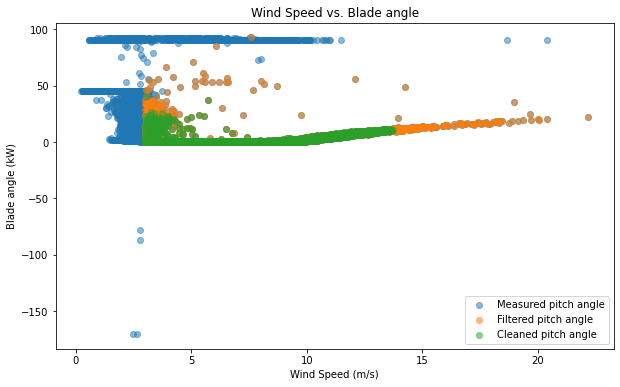

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(data['Wind speed (m/s)'], data['Blade angle (pitch position) A (°)'], alpha=0.5, label='Measured pitch angle')
plt.scatter(filtered_data['Wind speed (m/s)'], filtered_data['Blade angle (pitch position) A (°)'], alpha=0.5, label='Filtered pitch angle')
plt.scatter(filtered_data_cleaned['Wind speed (m/s)'], filtered_data_cleaned['Blade angle (pitch position) A (°)'], alpha=0.5, label='Cleaned pitch angle')
plt.title('Wind Speed vs. Blade angle')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Blade angle (kW)')
plt.legend()
plt.show()

**Insights:** Now the missing values in blade pitch angle have been imputed using k-NN method. The k-NN algorithm identifies the 'k' nearest data points with complete information on blade pitch angle for instances where this information was initially missing. The missing values are then imputed by averaging or weighting the values from these nearest neighbors. 

#### Performing cross-validation

It is important to perform cross validation of the imputation model.  This helps ensure that the imputation process generalizes well to different parts of the dataset, reducing the risk of overfitting.

In [32]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

X = filtered_data_cleaned.drop(columns=['Blade angle (pitch position) A (°)', 'IEC category', 'Message', '# Date and time'])

y = filtered_data_cleaned['Blade angle (pitch position) A (°)']

rf = RandomForestRegressor()

# Perform K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cross_val_scores = cross_val_score(rf, X, y, cv=kf)

print("Cross-Validation Scores:", cross_val_scores)

Cross-Validation Scores: [0.99968323 0.99334638 0.99992625 0.99994682 0.99973113]


**Insights:** The scores, ranging from 0.9968 to 0.9999, underscore the accuracy of imputed values, indicating that the kNN imputation has successfully captured the underlying patterns in the data.

In [33]:
filtered_data_cleaned["# Date and time"] = pd.to_datetime(filtered_data_cleaned["# Date and time"])
operating_time = filtered_data_cleaned["# Date and time"].diff().sum()

# Convert operating time to total hours

total_hours = operating_time.total_seconds()/3600
print(f'The underlying data set is based on 1 onshore wind turbine with a total operating hours of {round(total_hours,0)} hrs.')

The underlying data set is based on 1 onshore wind turbine with a total operating hours of 4326.0 hrs.


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
#! pip install windrose

**Wind rose diagram**

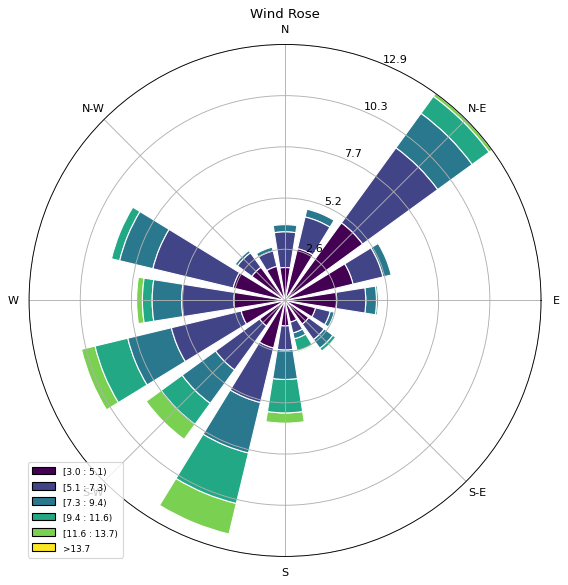

In [35]:
from windrose import WindroseAxes

ax = WindroseAxes.from_ax()
cmap = plt.get_cmap('viridis') 
ax.bar(filtered_data_cleaned['Wind direction (°)'], filtered_data_cleaned['Wind speed (m/s)'], 
       normed=True, opening=0.8, edgecolor='white', cmap = cmap)
ax.set_legend()
plt.title("Wind Rose")
plt.show()

**Insights:** The wind rose diagram provides insights into the prevailing wind directions, and the frequency of occurrence for different wind speeds. It is evident from the diagram that strong wind condition in wind direction between 30° and 60° with the wind speed up to 13.7 m/s. The strongest wind conditions are observed from directions 180° and 315°. This information, in conjunction with power produced, helps us better understand the correlation between wind speed and energy production at this location.

**Power Vs Wind speed curve**

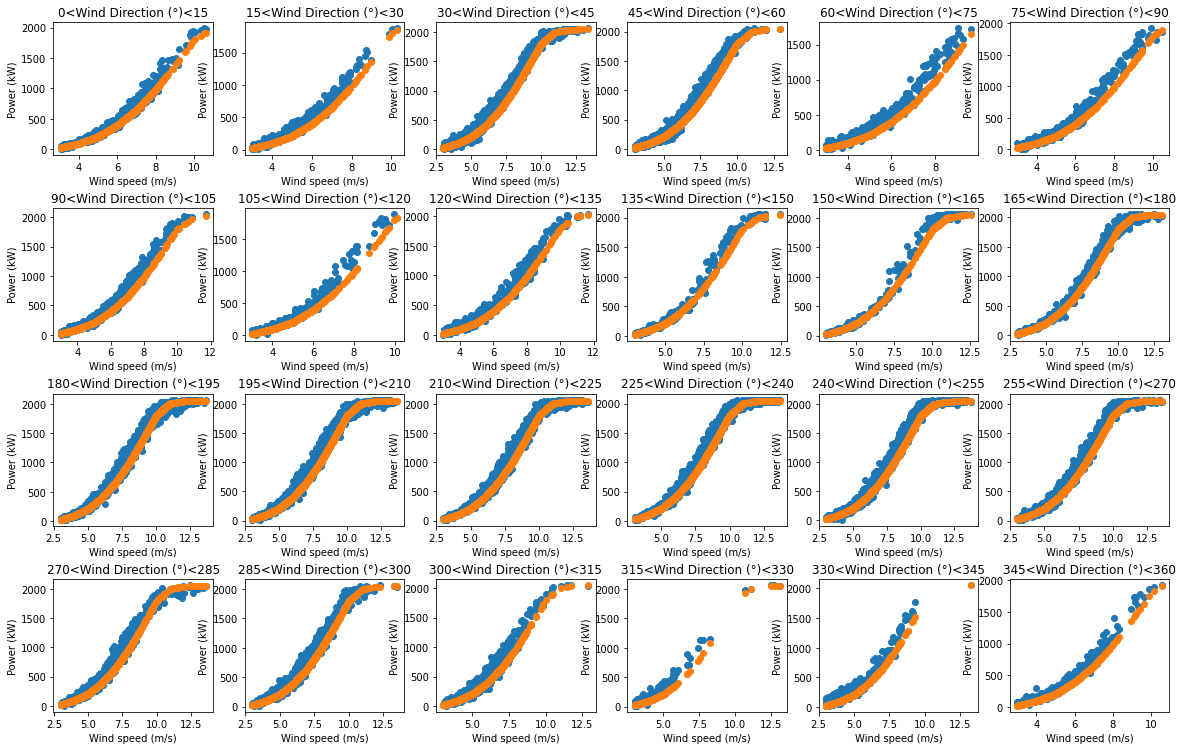

In [36]:
n = 0
plt.figure(figsize=(20,40))
for i in range(0,360,15):
    condition = (filtered_data_cleaned['Wind direction (°)']>i) & (filtered_data_cleaned['Wind direction (°)']<i+15)
    n += 1; fig = plt.subplot(12, 6, n)  # Subplot indexing starts from 1
    fig.scatter(filtered_data_cleaned.loc[condition,'Wind speed (m/s)'],filtered_data_cleaned.loc[condition,'Power (kW)'])
    fig.scatter(filtered_data_cleaned.loc[condition,'Wind speed (m/s)'],filtered_data_cleaned.loc[condition,'Potential power default PC (kW)'])
    fig.set_title(f'{i}<Wind Direction (°)<{(i+15)}')
    plt.xlabel('Wind speed (m/s)')
    plt.ylabel('Power (kW)')
    plt.subplots_adjust(hspace=0.4)
plt.show()

As stated in equation of power at the beginning, the ideal power curve is described as a function of the cube of wind speed and also influenced by the power coefficient Cp. Cp indicates how much power can be extracted by the rotor from the wind. In fact, Cp changes nonlinearly with pitch angle 𝛽 and tip-speed ratio 𝜆. Therefore,  Understanding the nonlinear relationships between blade pitch angle and power output is essential for designing and operating wind turbines efficiently. Furthermore, advanced control systems regulate rotor speed based on real-time environmental factors. Therefore, in addition to wind speed and blade pitch angle, rotor speed can provide helpful insights into the overall health and efficiency of the turbine. 

**Blade pitch angle**
<br>
The blade pitch angle refers to the angle between the chord line of a wind turbine blade and the plane perpendicular to the rotor's axis. The pitch angle is controlled by the pitch system of the turbine to optimize the performance and efficiency of the turbine.

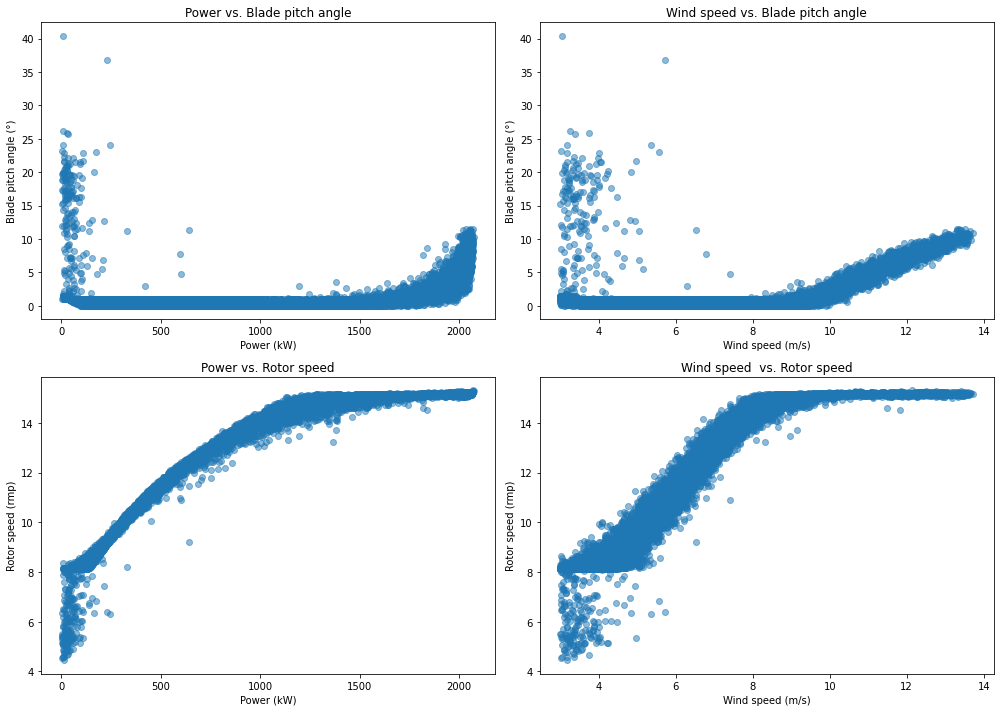

In [37]:
plt.figure(figsize=(14, 10))

plt.subplot(2,2,1)
plt.scatter(filtered_data_cleaned['Power (kW)'], filtered_data_cleaned['Blade angle (pitch position) A (°)'], alpha=0.5, label='Cleaned pitch angle')
plt.title('Power vs. Blade pitch angle')
plt.xlabel('Power (kW)')
plt.ylabel('Blade pitch angle (°)')

plt.subplot(2,2,2)
plt.scatter(filtered_data_cleaned['Wind speed (m/s)'], filtered_data_cleaned['Blade angle (pitch position) A (°)'], alpha=0.5, label='Cleaned pitch angle')
plt.title('Wind speed vs. Blade pitch angle')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Blade pitch angle (°)')


plt.subplot(2,2,3)
plt.scatter(filtered_data_cleaned['Power (kW)'], filtered_data_cleaned['Rotor speed (RPM)'], alpha=0.5, label='Cleaned rotor speed')
plt.title('Power vs. Rotor speed')
plt.xlabel('Power (kW)')
plt.ylabel('Rotor speed (rmp)')

plt.subplot(2,2,4)
plt.scatter(filtered_data_cleaned['Wind speed (m/s)'], filtered_data_cleaned['Rotor speed (RPM)'], alpha=0.5, label='Cleaned rotor speed')
plt.title('Wind speed  vs. Rotor speed')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Rotor speed (rmp)')
plt.tight_layout()
plt.show()

**Insights:** Large pitch angles are observed at certain data of wind speeds from 3 m/s to 5 m/s. This is mainly because the turbine may be adjusting the pitch angle to maximize power output at low wind conditions. 

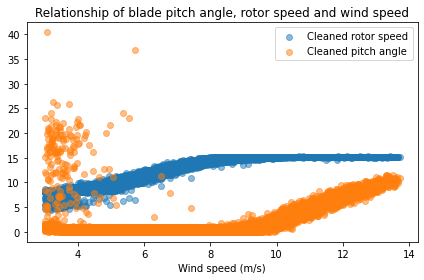

In [38]:
plt.scatter(filtered_data_cleaned['Wind speed (m/s)'], filtered_data_cleaned['Rotor speed (RPM)'], alpha=0.5, label='Cleaned rotor speed')
plt.scatter(filtered_data_cleaned['Wind speed (m/s)'], filtered_data_cleaned['Blade angle (pitch position) A (°)'], alpha=0.5, label='Cleaned pitch angle')
plt.xlabel('Wind speed (m/s)')
plt.title('Relationship of blade pitch angle, rotor speed and wind speed')
plt.legend()
plt.tight_layout()
plt.show()

**Insights:** The above figure depicts the turbine's behavior across different wind speeds and helps us understand how its control system responds to varying wind conditions. Rotor speed curve typically shows a gradual increase in rotor speed as wind speed increases, reaching a maximum at the rated wind speed. In the pitch angle curve, it is evidient that the pitch angle operates almost constant a low wind speed to extract maximum power available from the wind whereas it increases in high wind speeds to slow down the rotor at an optimum speed and to keep the power constant. Pitch angle outliers were observed at lower wind speeds. This might be related to wind run-up conditions, where the rotor speed is relatively low and the blade pitch are adjusted to maximize power production.

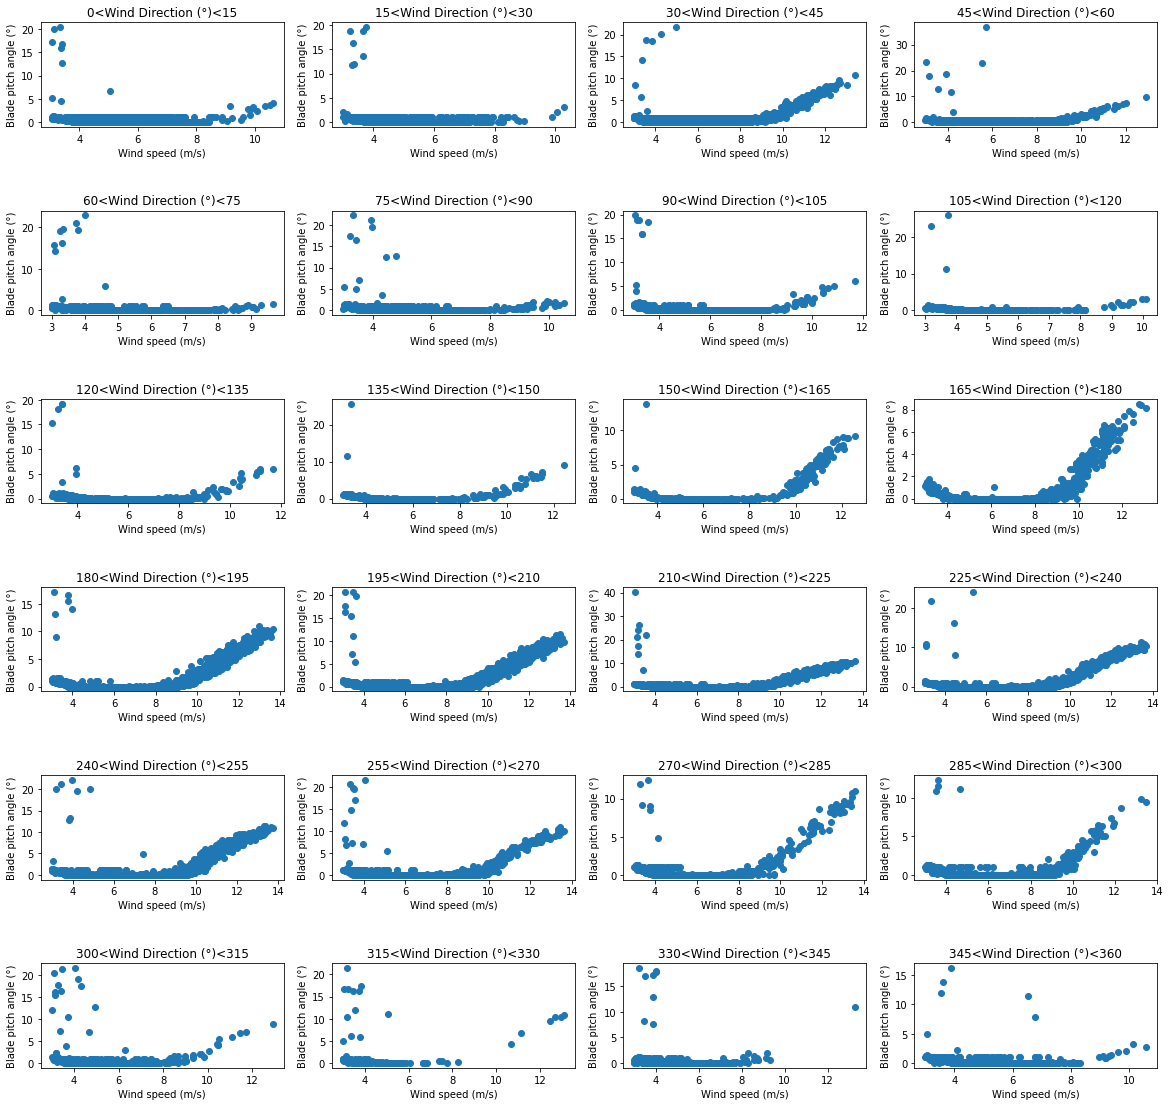

In [39]:
n = 0
plt.figure(figsize=(20,40))
for i in range(0,360,15):
    condition = (filtered_data_cleaned['Wind direction (°)']>i) & (filtered_data_cleaned['Wind direction (°)']<i+15)
    n += 1; fig = plt.subplot(12, 4, n)  # Subplot indexing starts from 1
    fig.scatter(filtered_data_cleaned.loc[condition,'Wind speed (m/s)'],filtered_data_cleaned.loc[condition,'Blade angle (pitch position) A (°)'])
    fig.set_title(f'{i}<Wind Direction (°)<{(i+15)}')
    plt.xlabel('Wind speed (m/s)')
    plt.ylabel('Blade pitch angle (°)')
    plt.subplots_adjust(hspace=0.8)
plt.show()

**Insights:**The above figures depict the relationship of blade pitch angle and wind speed for different wind directions. Here the response of pitch angle changes to wind directions and wind speeds can be observed. This explains that pitch angles outliers at low wind conditions can be attributed to its response to rapid changes in wind direction. This could be useful insight for turbine control system performance and improvement.

#### Average Power curve

In [40]:
# Set Date and time as index of Power 
filtered_data_cleaned.set_index('# Date and time', inplace=True)
filtered_data_cleaned['Power (kW)']

# Date and time
2021-01-01 17:00:00    706.923392
2021-01-01 17:10:00    697.602042
2021-01-01 17:20:00    789.303677
2021-01-01 17:30:00    845.318820
2021-01-01 17:40:00    866.879993
                          ...    
2021-06-30 14:20:00     36.660000
2021-06-30 17:20:00     43.709999
2021-06-30 23:10:00     50.639999
2021-06-30 23:20:00     97.330002
2021-06-30 23:30:00     73.730003
Name: Power (kW), Length: 19780, dtype: float64

**Average monthly power**

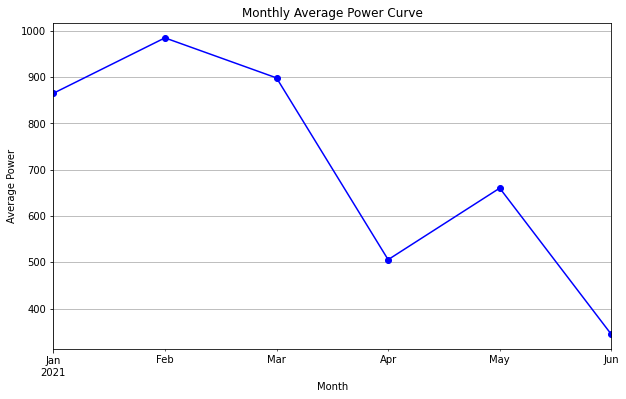

In [41]:
# Get monthly average power
monthly_avg_power_curve= filtered_data_cleaned['Power (kW)'].resample('M').mean()
plt.figure(figsize=(10, 6))
monthly_avg_power_curve.plot( linestyle='-', marker = 'o', color='b')
plt.title('Monthly Average Power Curve')
plt.xlabel('Month')
plt.ylabel('Average Power')
plt.grid(True)
plt.show()

**Daily power curve of each month**

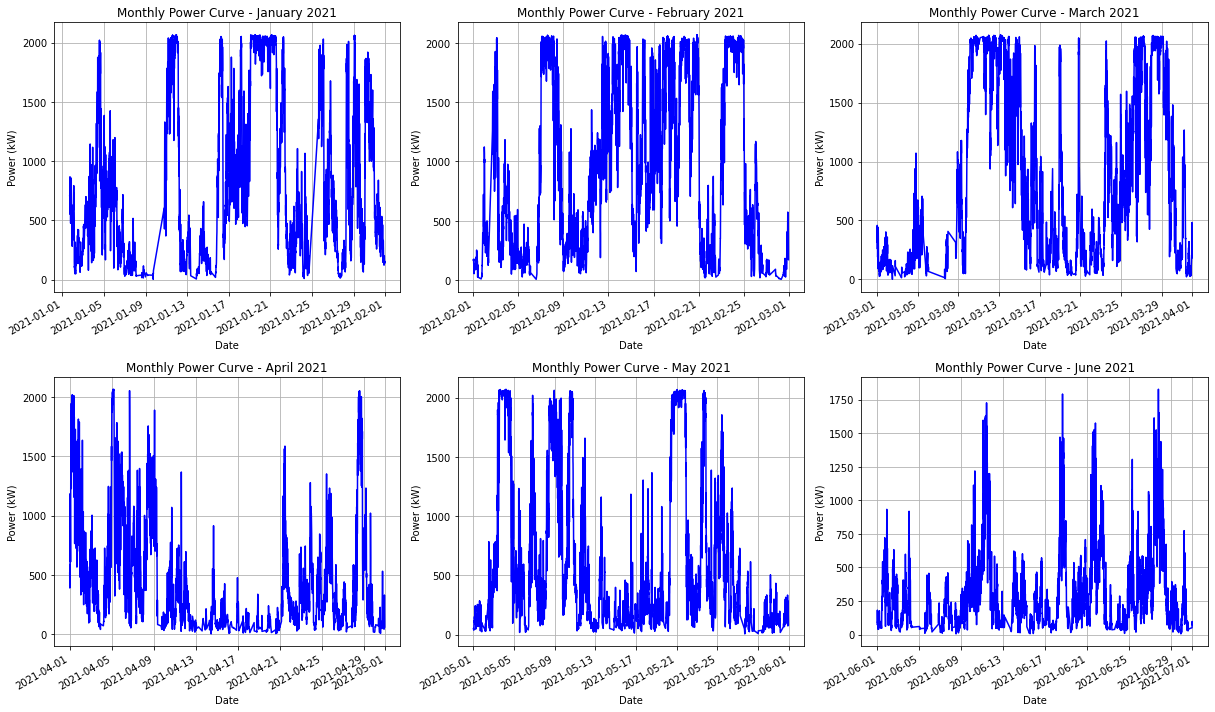

In [42]:
filtered_data_cleaned['Power (kW)'].index = pd.to_datetime(filtered_data_cleaned['Power (kW)'].index)

# Get monthly power curve
monthly_power_curve = filtered_data_cleaned['Power (kW)'].loc[filtered_data_cleaned.index.month <= 6]

# Plot for each month

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17, 10))
axes = axes.flatten()
for i, (month, value) in enumerate(monthly_power_curve.resample('M')):
    ax = axes[i]
    value.plot(ax=ax, linestyle='-', color='b')
    ax.set_title(f'Monthly Power Curve - {month.strftime("%B %Y")}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Power (kW)')
    ax.grid(True)

plt.tight_layout()
plt.show()

**Conclusion and insights**

The present study explored different types anomalities in SCADA dataset of an onshore wind turbine to improve power curve modeling. The findings suggest that using a multivariate data-driven model, combining environmental and operational parameters, could be a more effective approach for accurately modeling wind turbine power curves.